In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11769273513243567821, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 14898672018193866628
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:83:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 16744074379907682626
 physical_device_desc: "device: 1, name: GeForce GTX 1080 Ti, pci bus id: 0000:84:00.0, compute capability: 6.1", name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 8888285065592617999
 physical_device_desc: "device: 2, name: GeForce GTX 1080 Ti, pci bus id: 0000:87:00.0, compute capability: 6.1", name: "/device:GPU:3"
 device_type: "GPU"
 memory_limit: 10968950375
 locality {
   bus_id: 2
 }
 incarnation: 8218979223232748100
 physical_dev

In [3]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.4.0
dim_ordering: tf


Using TensorFlow backend.


In [4]:
import os
import numpy as np
np.random.seed(777)

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model

from keras.layers.core import Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.models import Model, load_model

from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

In [5]:
output_classes = 2
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 50

nb_train_samples = 103104
nb_validation_samples = 12288
nb_test_samples = 697

In [6]:
train_dir = 'data/train/'
validation_dir = 'data/validation'
test_dir = 'data/test'

In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 103104 images belonging to 2 classes.
Found 12288 images belonging to 2 classes.
Found 697 images belonging to 2 classes.


In [8]:
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import Activation
from keras.layers import MaxPool2D
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Lambda


def residual_block(input, input_channels=None, output_channels=None, kernel_size=(3, 3), stride=1):
    """
    full pre-activation residual block
    https://arxiv.org/pdf/1603.05027.pdf
    """
    if output_channels is None:
        output_channels = input.get_shape()[-1].value
    if input_channels is None:
        input_channels = output_channels // 4

    strides = (stride, stride)

    x = BatchNormalization()(input)
    x = Activation('relu')(x)
    x = Conv2D(input_channels, (1, 1))(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(input_channels, kernel_size, padding='same', strides=stride)(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(output_channels, (1, 1), padding='same')(x)

    if input_channels != output_channels or stride != 1:
        input = Conv2D(output_channels, (1, 1), padding='same', strides=strides)(input)

    x = Add()([x, input])
    return x


def attention_block(input, input_channels=None, output_channels=None, encoder_depth=1):
    """
    attention block
    https://arxiv.org/abs/1704.06904
    """

    p = 1
    t = 2
    r = 1

    if input_channels is None:
        input_channels = input.get_shape()[-1].value
    if output_channels is None:
        output_channels = input_channels

    # First Residual Block
    for i in range(p):
        input = residual_block(input)

    # Trunc Branch
    output_trunk = input
    for i in range(t):
        output_trunk = residual_block(output_trunk)

    # Soft Mask Branch

    ## encoder
    ### first down sampling
    output_soft_mask = MaxPool2D(padding='same')(input)  # 32x32
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)

    skip_connections = []
    for i in range(encoder_depth - 1):

        ## skip connections
        output_skip_connection = residual_block(output_soft_mask)
        skip_connections.append(output_skip_connection)
        # print ('skip shape:', output_skip_connection.get_shape())

        ## down sampling
        output_soft_mask = MaxPool2D(padding='same')(output_soft_mask)
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)

            ## decoder
    skip_connections = list(reversed(skip_connections))
    for i in range(encoder_depth - 1):
        ## upsampling
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)
        output_soft_mask = UpSampling2D()(output_soft_mask)
        ## skip connections
        output_soft_mask = Add()([output_soft_mask, skip_connections[i]])

    ### last upsampling
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)
    output_soft_mask = UpSampling2D()(output_soft_mask)

    ## Output
    output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
    output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
    output_soft_mask = Activation('sigmoid')(output_soft_mask)

    # Attention: (1 + output_soft_mask) * output_trunk
    output = Lambda(lambda x: x + 1)(output_soft_mask)
    output = Multiply()([output, output_trunk])  #

    # Last Residual Block
    for i in range(p):
        output = residual_block(output)

    return output

In [11]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dense
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Model
from keras.regularizers import l2

def AttentionResNet92(shape=(224, 224, 3), n_channels=64, n_classes=100,
                      dropout=0, regularization=0.01):
    """
    Attention-92 ResNet
    https://arxiv.org/abs/1704.06904
    """
    regularizer = l2(regularization)

    input_ = Input(shape=shape)
    x = Conv2D(n_channels, (7, 7), strides=(2, 2), padding='same')(input_) # 112x112
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)  # 56x56

    x = residual_block(x, output_channels=n_channels * 4)  # 56x56
    x = attention_block(x, encoder_depth=3)  # bottleneck 7x7

    x = residual_block(x, output_channels=n_channels * 8, stride=2)  # 28x28
    x = attention_block(x, encoder_depth=2)  # bottleneck 7x7
    x = attention_block(x, encoder_depth=2)  # bottleneck 7x7

    x = residual_block(x, output_channels=n_channels * 16, stride=2)  # 14x14
    x = attention_block(x, encoder_depth=1)  # bottleneck 7x7
    x = attention_block(x, encoder_depth=1)  # bottleneck 7x7
    x = attention_block(x, encoder_depth=1)  # bottleneck 7x7

    x = residual_block(x, output_channels=n_channels * 32, stride=2)  # 7x7
    x = residual_block(x, output_channels=n_channels * 32)
    x = residual_block(x, output_channels=n_channels * 32)

    pool_size = (x.get_shape()[1].value, x.get_shape()[2].value)
    x = AveragePooling2D(pool_size=pool_size, strides=(1, 1))(x)
    x = Flatten()(x)
    if dropout:
        x = Dropout(dropout)(x)
    output = Dense(n_classes, kernel_regularizer=regularizer, activation=tf.nn.softmax)(x)

    model = Model(input_, output)
    return model


def AttentionResNet56(shape=(224, 224, 3), n_channels=64, n_classes=100,
                      dropout=0, regularization=0.01):
    """
    Attention-56 ResNet
    https://arxiv.org/abs/1704.06904
    """

    regularizer = l2(regularization)

    input_ = Input(shape=shape)
    x = Conv2D(n_channels, (7, 7), strides=(2, 2), padding='same')(input_) # 112x112
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)  # 56x56

    x = residual_block(x, output_channels=n_channels * 4)  # 56x56
    x = attention_block(x, encoder_depth=3)  # bottleneck 7x7

    x = residual_block(x, output_channels=n_channels * 8, stride=2)  # 28x28
    x = attention_block(x, encoder_depth=2)  # bottleneck 7x7

    x = residual_block(x, output_channels=n_channels * 16, stride=2)  # 14x14
    x = attention_block(x, encoder_depth=1)  # bottleneck 7x7

    x = residual_block(x, output_channels=n_channels * 32, stride=2)  # 7x7
    x = residual_block(x, output_channels=n_channels * 32)
    x = residual_block(x, output_channels=n_channels * 32)

    pool_size = (x.get_shape()[1].value, x.get_shape()[2].value)
    x = AveragePooling2D(pool_size=pool_size, strides=(1, 1))(x)
    x = Flatten()(x)
    if dropout:
        x = Dropout(dropout)(x)
    output = Dense(n_classes, kernel_regularizer=regularizer, activation=tf.nn.softmax)(x)

    model = Model(input_, output)
    return model

In [12]:
model = AttentionResNet56(n_classes=2)

In [14]:
# sgd_opt = SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)
# adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
adam_opt=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=True)
sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
rmsp_opt = RMSprop(lr=1e-4, decay=0.9)

model.compile(optimizer= adam_opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [15]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, verbose = 1)]

history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size,
  callbacks = callbacks)

# with open('models/vgg19_history.txt','w') as f:
#     f.write(str(history.history))

Epoch 1/50
3222/3222 [==============================] - 1812s 562ms/step - loss: 5.0940 - acc: 0.6860 - val_loss: 5.0880 - val_acc: 0.6862
Epoch 2/50
3222/3222 [==============================] - 1804s 560ms/step - loss: 5.0872 - acc: 0.6861 - val_loss: 5.0825 - val_acc: 0.6862
Epoch 3/50
3222/3222 [==============================] - 1790s 556ms/step - loss: 5.0825 - acc: 0.6861 - val_loss: 5.0785 - val_acc: 0.6862
Epoch 4/50
3222/3222 [==============================] - 1791s 556ms/step - loss: 5.0791 - acc: 0.6861 - val_loss: 5.0755 - val_acc: 0.6862
Epoch 5/50
3222/3222 [==============================] - 1806s 561ms/step - loss: 5.0764 - acc: 0.6861 - val_loss: 5.0731 - val_acc: 0.6862
Epoch 6/50
3222/3222 [==============================] - 1786s 554ms/step - loss: 5.0742 - acc: 0.6861 - val_loss: 5.0711 - val_acc: 0.6862
Epoch 00006: early stopping


In [ ]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

# plt.figure()
# N = epochs
# plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
# plt.title("Training Loss and Accuracy")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="upper left")

In [16]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  5.1508846807479856
Validation Accuracy:  0.68125


In [17]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

22/21 [==============================] - 9s 422ms/step
No of errors = 216/697


Confusion Matrix
[[  0 216]
 [  0 481]]


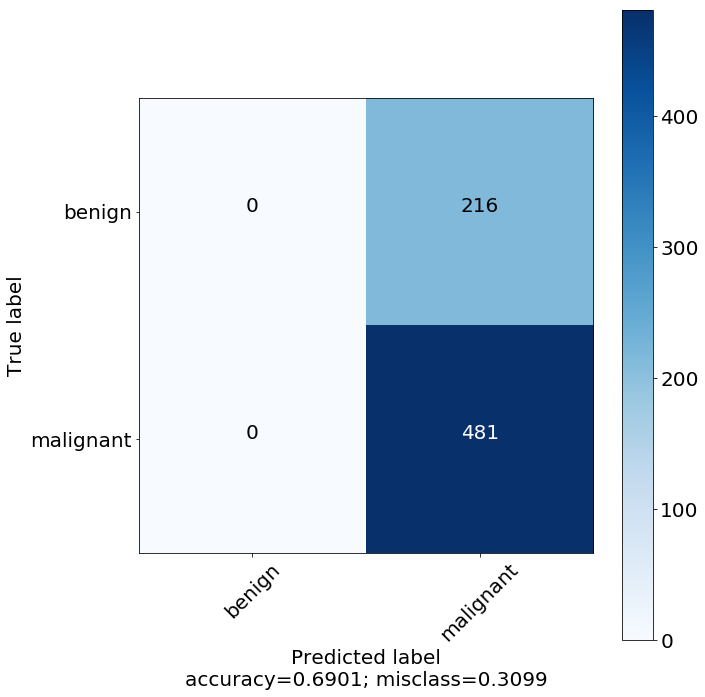

In [18]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels, title=' ')

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[  0 216]
 [  0 481]]
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00       216
   malignant       0.69      1.00      0.82       481

   micro avg       0.69      0.69      0.69       697
   macro avg       0.35      0.50      0.41       697
weighted avg       0.48      0.69      0.56       697



In [20]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  69.01004304160688
Sensitivity :  nan
Specificity :  69.01004304160688


In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc*100))
print('Precision: {:.4f}'.format(prec*100))
print('Recall:    {:.4f}'.format(recall*100))
print('F1:        {:.4f}'.format(f1*100))

Accuracy:  69.0100
Precision: 69.0100
Recall:    100.0000
F1:        81.6638


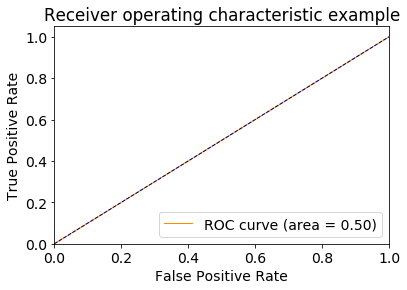

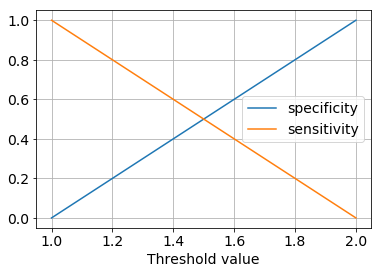

In [22]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [23]:
model.save('models/17.AttentionResNet56-BreaKHis-Model.h5')
model.save_weights('models/17.AttentionResNet56-BreaKHis-Weights.h5')

___

In [24]:
adam_opt2=Adam(lr=1e-05, beta_1=0.6, beta_2=0.9, epsilon=None, decay=0.0, amsgrad=True)
model.compile(optimizer= adam_opt2, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [25]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, verbose = 1)]

history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size,
  callbacks = callbacks)

# with open('models/vgg19_history2.txt','w') as f:
#     f.write(str(history.history))

Epoch 1/50
3222/3222 [==============================] - 1814s 563ms/step - loss: 4.6496 - acc: 0.6977 - val_loss: 0.4124 - val_acc: 0.8253
Epoch 2/50
3222/3222 [==============================] - 1846s 573ms/step - loss: 0.3295 - acc: 0.8590 - val_loss: 0.3382 - val_acc: 0.8449
Epoch 3/50
3222/3222 [==============================] - 1836s 570ms/step - loss: 0.2449 - acc: 0.8970 - val_loss: 0.2712 - val_acc: 0.8765
Epoch 4/50
3222/3222 [==============================] - 1822s 565ms/step - loss: 0.1937 - acc: 0.9199 - val_loss: 0.3671 - val_acc: 0.8519
Epoch 5/50
3222/3222 [==============================] - 1857s 576ms/step - loss: 0.1527 - acc: 0.9388 - val_loss: 0.2428 - val_acc: 0.9003
Epoch 6/50
3222/3222 [==============================] - 1834s 569ms/step - loss: 0.1095 - acc: 0.9574 - val_loss: 0.3474 - val_acc: 0.8696
Epoch 7/50
3222/3222 [==============================] - 1829s 568ms/step - loss: 0.0809 - acc: 0.9701 - val_loss: 0.3162 - val_acc: 0.8960
Epoch 8/50
3222/3222 [=====

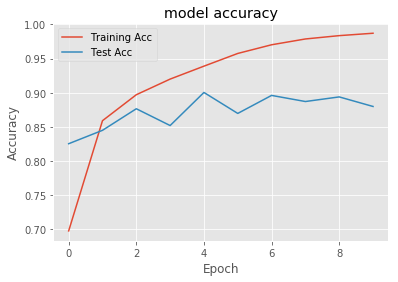

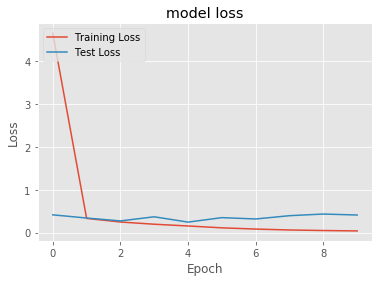

In [26]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

# plt.figure()
# N = 12
# plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
# plt.title("Training Loss and Accuracy")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="upper left")

In [27]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.44432269155979154
Validation Accuracy:  0.875625


In [28]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

22/21 [==============================] - 9s 398ms/step
No of errors = 55/697


Confusion Matrix
[[208   8]
 [ 47 434]]


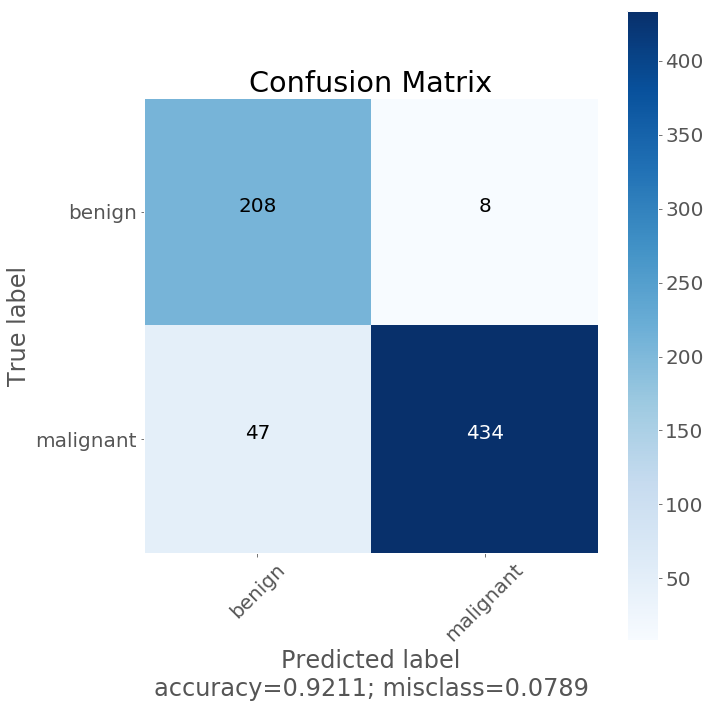

In [29]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
# fig.savefig('plots/1.Xception-CM.png') 
plt.figure(figsize=(10,10))

plot_confusion_matrix(cm, classes=labels, title='Confusion Matrix')

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report


y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[208   8]
 [ 47 434]]
              precision    recall  f1-score   support

      benign       0.82      0.96      0.88       216
   malignant       0.98      0.90      0.94       481

   micro avg       0.92      0.92      0.92       697
   macro avg       0.90      0.93      0.91       697
weighted avg       0.93      0.92      0.92       697



In [31]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  92.1090387374462
Sensitivity :  81.56862745098039
Specificity :  98.19004524886877


In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc*100))
print('Precision: {:.4f}'.format(prec*100))
print('Recall:    {:.4f}'.format(recall*100))
print('F1:        {:.4f}'.format(f1*100))

Accuracy:  92.1090
Precision: 98.1900
Recall:    90.2287
F1:        94.0412


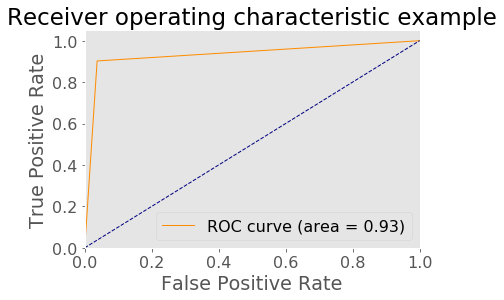

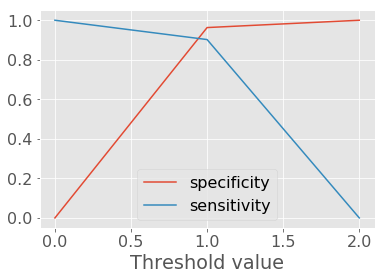

In [33]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 16})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [34]:
model.save('models/17.AttentionResNet56-2-BreaKHis-Model.h5')
model.save_weights('models/17.AttentionResNet56-2-BreaKHis-Weights.h5')

___